<a href="https://colab.research.google.com/github/casperbh96/mbml/blob/master/Data_Preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the packages

In [0]:
# Install Pyro, if necessary
!pip install pyro-ppl

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
from sklearn.impute import SimpleImputer
from sklearn import linear_model
import torch

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam

pd.set_option('display.max_columns', 50)
%matplotlib inline

# Loading the dataset

This is the Santander Product Recommendation dataset from [Kaggle](https://www.kaggle.com/c/santander-product-recommendation/data).

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#train_path = 'data/train_ver2.csv'
train_path = '/content/gdrive/My Drive/DTU/Model-based machined learning/project/data/train_ver2.csv'

train_df = pd.read_csv(train_path, parse_dates=['fecha_dato', 'fecha_alta', 'ult_fec_cli_1t'],
                 sep=",",na_values = ['?', 'NA'], nrows = 100000)

train_df.head(5)

,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,ult_fec_cli_1t,indrel_1mes,tiprel_1mes,indresi,indext,conyuemp,canal_entrada,indfall,tipodom,cod_prov,nomprov,ind_actividad_cliente,renta,segmento,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
0,2015-01-28,1375586,N,ES,H,35,2015-01-12,0.0,6,1.0,NaT,1.0,A,S,N,NaN,KHL,N,1.0,29.0,MALAGA,1.0,87218.10,02 - PARTICULARES,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
1,2015-01-28,1050611,N,ES,V,23,2012-08-10,0.0,35,1.0,NaT,1.0,I,S,S,NaN,KHE,N,1.0,13.0,CIUDAD REAL,0.0,35548.74,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
2,2015-01-28,1050612,N,ES,V,23,2012-08-10,0.0,35,1.0,NaT,1.0,I,S,N,NaN,KHE,N,1.0,13.0,CIUDAD REAL,0.0,122179.11,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
3,2015-01-28,1050613,N,ES,H,22,2012-08-10,0.0,35,1.0,NaT,1.0,I,S,N,NaN,KHD,N,1.0,50.0,ZARAGOZA,0.0,119775.54,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
4,2015-01-28,1050614,N,ES,V,23,2012-08-10,0.0,35,1.0,NaT,1.0,A,S,N,NaN,KHE,N,1.0,50.0,ZARAGOZA,1.0,NaN,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0


In [0]:
#test_path = 'data/test_ver2.csv'
test_path = '/content/gdrive/My Drive/DTU/Model-based machined learning/project/data/test_ver2.csv'

test_df = pd.read_csv(test_path, parse_dates=['fecha_dato', 'fecha_alta', 'ult_fec_cli_1t'],
                      sep=",",na_values = ['?', 'NA'])

test_df.head(5)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,ult_fec_cli_1t,indrel_1mes,tiprel_1mes,indresi,indext,conyuemp,canal_entrada,indfall,tipodom,cod_prov,nomprov,ind_actividad_cliente,renta,segmento
0,2016-06-28,15889,F,ES,V,56,1995-01-16,0,256,1,NaT,1.0,A,S,N,N,KAT,N,1,28.0,MADRID,1,326124.90,01 - TOP
1,2016-06-28,1170544,N,ES,H,36,2013-08-28,0,34,1,NaT,1.0,I,S,N,NaN,KAT,N,1,3.0,ALICANTE,0,NA,02 - PARTICULARES
2,2016-06-28,1170545,N,ES,V,22,2013-08-28,0,34,1,NaT,1.0,A,S,N,NaN,KHE,N,1,15.0,"CORUÑA, A",1,NA,03 - UNIVERSITARIO
3,2016-06-28,1170547,N,ES,H,22,2013-08-28,0,34,1,NaT,1.0,I,S,N,NaN,KHE,N,1,8.0,BARCELONA,0,148402.98,03 - UNIVERSITARIO
4,2016-06-28,1170548,N,ES,H,22,2013-08-28,0,34,1,NaT,1.0,I,S,N,NaN,KHE,N,1,7.0,"BALEARS, ILLES",0,106885.80,03 - UNIVERSITARIO


In [0]:
print(train_df.shape)
print(test_df.shape)

(100000, 48)
(929615, 24)


In [0]:
columns_num = ['age',
               'renta',
               'antiguedad',
               'ncodpers']

columns_cat = ['ind_empleado',
               'pais_residencia',   
               'sexo',
               'ind_nuevo',
               'indrel',                    
               'tiprel_1mes', 
               'indresi',
               'indrel_1mes',
               'indext',
               'canal_entrada',
               'conyuemp',           #100% of NaN values (see below)
               'indfall',
               'nomprov',
               'segmento',
               'tipodom',
               'cod_prov',
               'ind_actividad_cliente']

columns_date =['fecha_dato',
               'fecha_alta',
               'ult_fec_cli_1t']    #100% of NaN values (see below)

# Descriptive Statistics & Visualization

In [0]:
print("age value statistics", train_df['age'].describe())
print("\n \n \n renta value statistics \n\n", train_df['renta'].describe())

print("\n\n\n categorical value statistics \n\n", train_df[columns_cat].describe())
print("\n\n\n date value statistics \n\n", train_df[columns_date].describe())

age value statistics count     100000
unique       100
top           23
freq       22099
Name: age, dtype: object

 
 
 renta value statistics 

 count    8.171600e+04
mean     1.155589e+05
std      1.594097e+05
min      2.539800e+03
25%      6.217089e+04
50%      8.961021e+04
75%      1.330239e+05
max      2.425324e+07
Name: renta, dtype: float64


NameError: ignored

In [0]:
def plot_dates(datetimes, title):
    # Size of figure
    plt.figure(figsize=(15,8))

    # Plot the values
    sns.barplot(
        datetimes.index, 
        datetimes.values,
        alpha=0.7,
        color=(0, 0, 0.9)
    )

    # Make labels x: yyyymm format
    plt.xlabel('Year and month ', fontsize=16)
    plt.ylabel('Number of customers on date', fontsize=16)

    # Make xlabel vertical instead of horizontal
    plt.xticks(rotation='vertical')
    
    plt.suptitle(title, fontsize=24)

    plt.show()

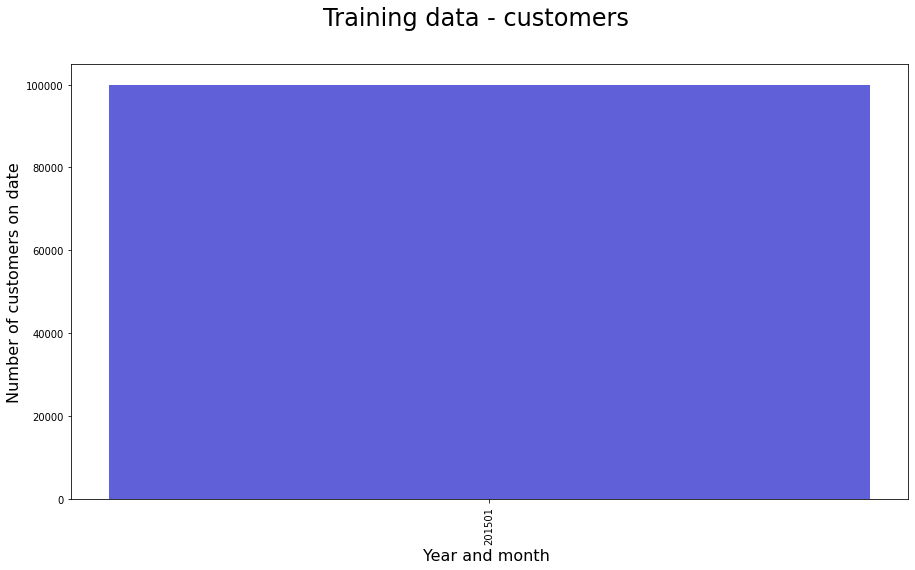

In [0]:
yearmonth = train_df['fecha_dato'].apply(
    lambda x: (100*x.year) + x.month
).value_counts()

plot_dates(yearmonth, 'Training data - customers')

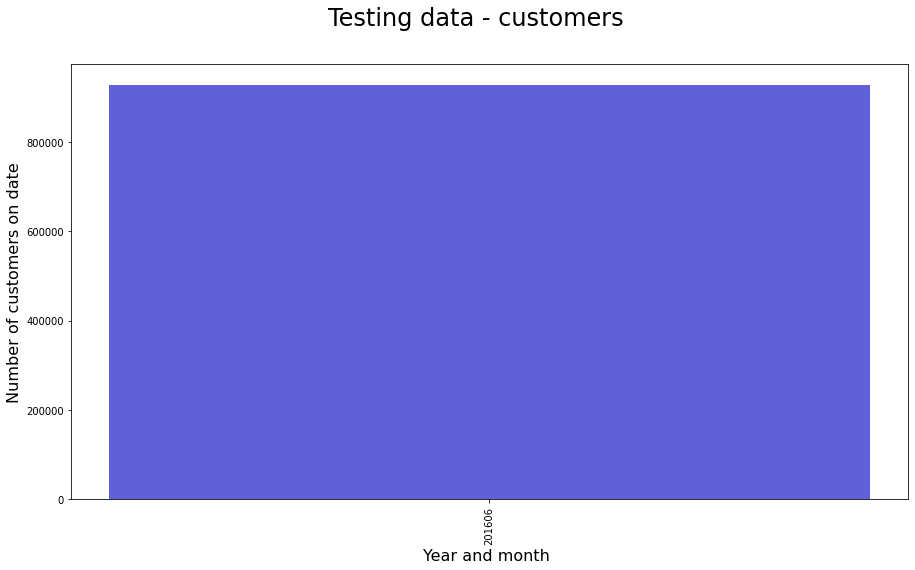

In [0]:
test_yearmonth = test_df['fecha_dato'].apply(
    lambda x: (100*x.year) + x.month
).value_counts()

plot_dates(test_yearmonth, 'Testing data - customers')

# Cleaning the dataset

In [0]:
print("Training NaN values percentages \n\n",(train_df.isna().sum()/df.shape[0])*100)
print("\n\n Testing NaN values percentages \n\n",(test_df.isna().sum()/test_df.shape[0])*100)

Training NaN values percentages 

 fecha_dato                 0.000
ncodpers                   0.000
ind_empleado               0.683
pais_residencia            0.683
sexo                       0.683
age                        0.000
fecha_alta                 0.683
ind_nuevo                  0.683
antiguedad                 0.000
indrel                     0.683
ult_fec_cli_1t            99.872
indrel_1mes                0.683
tiprel_1mes                0.683
indresi                    0.683
indext                     0.683
conyuemp                 100.000
canal_entrada              0.688
indfall                    0.683
tipodom                    0.683
cod_prov                   0.769
nomprov                    0.769
ind_actividad_cliente      0.683
renta                     18.284
segmento                   0.691
ind_ahor_fin_ult1          0.000
ind_aval_fin_ult1          0.000
ind_cco_fin_ult1           0.000
ind_cder_fin_ult1          0.000
ind_cno_fin_ult1           0.000
ind_ctju

In [0]:
def nan_value_check(value):
    check = str(val).replace(' ', '').lower()
    if check == '?' or check == 'na' or check == 'nan':
        return True
    else:
        return False

## Removing the obvious features

We can clearly see that 'ult_fec_cli_1t' and 'conyuemp' should be removed, because they have almost 100% NaN values, which we cannot use for anything.

In [0]:
# remove columns with too many NaN values
drop_features = ['ult_fec_cli_1t', 'conyuemp']
#nomprov and cod_prov are the same information
drop_features.append('nomprov')
#tipodom has only one value
drop_features.append('tipodom')

In [0]:
train_df = train_df.drop(drop_features, axis=1)
test_df = test_df.drop(drop_features, axis=1)

In [0]:
columns_date.remove(drop_features[0])
columns_cat.remove(drop_features[1])
columns_cat.remove(drop_features[2])
columns_cat.remove(drop_features[3])

## The feature 'renta'

This feature has nan values, but not enough to where we want to drop it. Instead, we choose to prepare it for imputation.

In [0]:
# make nan values into numpy nan values
train_df['renta'] = train_df['renta'].fillna(np.nan)

# test data is type object
new_vals = []
for val in test_df['renta']:
    if nan_value_check(val):
        val = np.nan
    new_vals.append(val)
    
test_df['renta'] = np.array(new_vals, dtype=float)

###test_df['renta'] = test_df['renta'].fillna(np.nan) why not only this line ?

We have chosen to impute the values for renta, since the feature could potentially have good predictive power, in terms of which products a customer might want to purchase.

In [0]:
print("Number of Nan values in column renta before the process:")
print(train_df['renta'].isna().sum())
print(test_df['renta'].isna().sum())

imputer = SimpleImputer(missing_values=np.nan, strategy="mean")
train_df['renta'] = imputer.fit_transform(train_df['renta'].values.reshape(-1, 1))

imputer = SimpleImputer(missing_values=np.nan, strategy="mean")
test_df['renta'] = imputer.fit_transform(test_df['renta'].values.reshape(-1, 1))

print("\nAfter the imputation:")
print(train_df['renta'].isna().sum())
print(test_df['renta'].isna().sum())

Number of Nan values in column renta before the process:
18284
227965

After the imputation:
0
0


## The rest of the data

We choose to drop the rest of the rows that contains NaN values, since we can see that it is such a small percentage that it won't matter.

In [0]:
train_df = train_df.dropna(axis=0, how='any')
test_df = test_df.dropna(axis=0, how='any')

## The feature "indrel_1mes"

This feature can take only 5 different values, but actually, we can more types because some of the numbers are "float" while others are "string".


In [0]:
new_vals = []
for val in test_df["indrel_1mes"]:
  if type(val)=='str':
    val = float(val)
  new_vals.append(val)
test_df["indrel_1mes"] = np.array(new_vals, dtype=float)

new_vals = []
for val in train_df["indrel_1mes"]:
  if type(val)=='str':
    val = float(val)
  new_vals.append(val)
train_df["indrel_1mes"] = np.array(new_vals, dtype=float)

## A quick check on the total number of NaN values

In [0]:
train_nan_values = 0
test_nan_values = 0

for name, values in train_df.iteritems():
    for val in values:
        if nan_value_check(val):
            train_nan_values += 1

for name, values in test_df.iteritems():
    for val in values:
        if nan_value_check(val):
            test_nan_values += 1
            
print(f'There are {train_nan_values} NaN values in training dataset')
print(f'There are {test_nan_values} NaN values in testing dataset')

There are 0 NaN values in training dataset
There are 0 NaN values in testing dataset


# Preparing X and Y values

In this section, we want to prepare our inputs and outputs of the model. In particular, we want to include the prior information of which products the customer is already paying for.

In [0]:
y_variables = ['ind_ahor_fin_ult1', 'ind_aval_fin_ult1',
       'ind_cco_fin_ult1', 'ind_cder_fin_ult1', 'ind_cno_fin_ult1',
       'ind_ctju_fin_ult1', 'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1',
       'ind_ctpp_fin_ult1', 'ind_deco_fin_ult1', 'ind_deme_fin_ult1',
       'ind_dela_fin_ult1', 'ind_ecue_fin_ult1', 'ind_fond_fin_ult1',
       'ind_hip_fin_ult1', 'ind_plan_fin_ult1', 'ind_pres_fin_ult1',
       'ind_reca_fin_ult1', 'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1',
       'ind_viv_fin_ult1', 'ind_nomina_ult1', 'ind_nom_pens_ult1',
       'ind_recibo_ult1']

y_train = train_df[y_variables]
X_train = train_df
X_test = test_df

In [0]:
X_train.head(5)
print(X_train.shape)
print(X_test.shape)

(99218, 44)
(923309, 20)


## Encoding the dataset

To be able to use our dataset, we must encode all features, so that they appear as numbers instead of strings, datetimes, or other datatypes.

### Columns of type 'object'

In [0]:
X_cat = np.concatenate([pd.get_dummies(X_train[x]) for x in columns_cat], axis=1)
print(X_cat.shape)

(99218, 119)


In [0]:
X_essai = np.concatenate([pd.get_dummies(X_test["indrel_1mes"]), np.zeros((X_test.shape[0],1))], axis=1)

In [0]:
for column in columns_cat:
  print("____")
  print(column)
  L = []
  for i in X_train[column]:
    if i not in L:
      L.append(i)
  print(L)
  L = []
  for i in X_test[column]:
    if i not in L:
      L.append(i)
  print(L)

____
ind_empleado
['N']
['F', 'N', 'A', 'B', 'S']
____
pais_residencia
['ES']
['ES', 'PY', 'BO', 'IT', 'DE']
____
sexo
['H', 'V']
['V', 'H']
____
ind_nuevo
[0.0, 1.0]
[0, 1]
____
indrel
[1.0, 99.0]
[1, 99]
____
tiprel_1mes
['A', 'I']
['A', 'I', 'P']
____
indresi
['S']
['S', 'N']
____
indrel_1mes
[1.0]
[1.0, 3.0]
____
indext
['N', 'S']
['N', 'S']
____
canal_entrada
['KHL', 'KHE', 'KHD', 'KFA', 'KFC', 'KAT', 'KAZ', 'RED', 'KHC', 'KHK', 'KGN', 'KHM', 'KHO', 'KDH', 'KEH', 'KAD', 'KBG', 'KGC', 'KHF', 'KFK', 'KHA', 'KAF', 'KGX', 'KFD', 'KAG', 'KFG', 'KAB', 'KCC', 'KAE', 'KAH', 'KAR', 'KFJ', 'KFL', 'KAI', 'KFU', 'KAQ', 'KHN', 'KFS', 'KAA', 'KFP', 'KAJ', 'KFN', 'KGV', 'KGY', 'KFF', 'KAP']
['KAT', 'KHE', 'KFC', 'KHN', 'KFA', 'KHM', 'KHL', 'RED', 'KHQ', 'KHO', 'KHK', 'KAZ', 'KEH', 'KBG', 'KHF', 'KHC', 'KHD', 'KAK', 'KAD', 'KDH', 'KGC', 'KFK', 'KGN', 'KHP', 'KHS', '013', 'KFD', 'KEW', 'KEG', 'KAE', 'KAB', 'KAG', 'KCC', 'KAF', 'KAC', 'KAY', 'KES', 'KDU', 'KAA', 'KAP', 'KEN', 'KBZ', 'KEY', '007', '

In [0]:
totaltrain = 0
totaltest = 0
for column in columns_cat:

  train_cat_encoded = pd.get_dummies(X_train[column])
  test_cat_encoded = pd.get_dummies(X_test[column])
  L = []
  J = []
  print("___")
  totaltrain += train_cat_encoded.shape[1]
  totaltest += test_cat_encoded.shape[1]
  print(column)
  print(train_cat_encoded.shape[1])
  print(test_cat_encoded.shape[1])
print(totaltrain)
print(totaltest)

___
ind_empleado
1
5
___
pais_residencia
1
5
___
sexo
2
2
___
ind_nuevo
2
2
___
indrel
2
2
___
tiprel_1mes
2
3
___
indresi
1
2
___
indrel_1mes
1
2
___
indext
2
2
___
canal_entrada
46
162
___
indfall
2
2
___
segmento
3
3
___
cod_prov
52
52
___
ind_actividad_cliente
2
2
119
246


In [0]:
X_train = X_train.drop(columns_cat, axis=1)
X_test = X_test.drop(columns_cat, axis=1)

Here, there is a problam because the number of columns in test_cat_encoded is bigger than the numberof clums in train_cat_encoded, but it's important that our two dataset have the same number of columns

In [0]:
X_train = pd.concat([X_train, train_cat_encoded], axis=1)
X_test = pd.concat([X_test, test_cat_encoded], axis=1)

In [0]:
X_train.head(5)

,fecha_dato,ncodpers,age,fecha_alta,antiguedad,renta,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1,0.0,1.0
0,2015-01-28,1375586,35,2015-01-12,6,87218.100000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,1
1,2015-01-28,1050611,23,2012-08-10,35,35548.740000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,1,0
2,2015-01-28,1050612,23,2012-08-10,35,122179.110000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,1,0
3,2015-01-28,1050613,22,2012-08-10,35,119775.540000,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,1,0
4,2015-01-28,1050614,23,2012-08-10,35,115558.897359,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,1


In [0]:
X_test.head(5)

,fecha_dato,ncodpers,age,fecha_alta,antiguedad,renta,0,1
0,2016-06-28,15889,56,1995-01-16,256,326124.900000,0,1
1,2016-06-28,1170544,36,2013-08-28,34,134087.870595,1,0
2,2016-06-28,1170545,22,2013-08-28,34,134087.870595,0,1
3,2016-06-28,1170547,22,2013-08-28,34,148402.980000,1,0
4,2016-06-28,1170548,22,2013-08-28,34,106885.800000,1,0


### Columns of type 'datetime64'

In [0]:
def datetime_to_features(timestamp):
    year = timestamp.year
    month = timestamp.month
    day = timestamp.day
    
    return year, month, day

In [0]:
def datetimes_to_features(dt_features):
    data = pd.DataFrame()
    for name, values in dt_features.iteritems():
        year = []
        month = []
        day = []

        for val in values:
            y,m,d = datetime_to_features(val)
            year.append(y) ; month.append(m) ; day.append(d)

        new_features = {name + '_year'  : year,
                        name + '_month' : month,
                        name + '_day'   : day}
        
        new_data = pd.DataFrame(new_features)
        data = pd.concat([data, new_data], axis=1)
        
    return data

In [0]:
train_new_features = datetimes_to_features(X_train[columns_date])
test_new_features = datetimes_to_features(X_test[columns_date])

In [0]:
X_train = X_train.drop(columns_date, axis=1)
X_test = X_test.drop(columns_date, axis=1)

In [0]:
X_train = pd.concat([X_train, train_new_features], axis=1)
X_test = pd.concat([X_test, test_new_features], axis=1)

In [0]:
X_train.head(5)

,age,antiguedad,renta,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,...,nomprov_OURENSE,nomprov_PALENCIA,"nomprov_PALMAS, LAS",nomprov_PONTEVEDRA,"nomprov_RIOJA, LA",nomprov_SALAMANCA,nomprov_SANTA CRUZ DE TENERIFE,nomprov_SEGOVIA,nomprov_SEVILLA,nomprov_SORIA,nomprov_TERUEL,nomprov_TOLEDO,nomprov_VALENCIA,nomprov_VALLADOLID,nomprov_ZAMORA,nomprov_ZARAGOZA,segmento_01 - TOP,segmento_02 - PARTICULARES,segmento_03 - UNIVERSITARIO,fecha_dato_year,fecha_dato_month,fecha_dato_day,fecha_alta_year,fecha_alta_month,fecha_alta_day
0,35,6,87218.100000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2015.0,1.0,28.0,2015.0,1.0,12.0
1,23,35,35548.740000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2015.0,1.0,28.0,2012.0,8.0,10.0
2,23,35,122179.110000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2015.0,1.0,28.0,2012.0,8.0,10.0
3,22,35,119775.540000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2015.0,1.0,28.0,2012.0,8.0,10.0
4,23,35,105122.643198,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2015.0,1.0,28.0,2012.0,8.0,10.0


In [0]:
X_test.head(5)

,age,antiguedad,renta,ncodpers,indrel,ind_nuevo,indrel_1mes,tipodom,cod_prov,ind_actividad_cliente,ind_empleado_A,ind_empleado_B,ind_empleado_F,ind_empleado_N,ind_empleado_S,pais_residencia_BO,pais_residencia_DE,pais_residencia_ES,pais_residencia_IT,pais_residencia_PY,sexo_H,sexo_V,tiprel_1mes_A,tiprel_1mes_I,tiprel_1mes_P,...,nomprov_PALENCIA,"nomprov_PALMAS, LAS",nomprov_PONTEVEDRA,"nomprov_RIOJA, LA",nomprov_SALAMANCA,nomprov_SANTA CRUZ DE TENERIFE,nomprov_SEGOVIA,nomprov_SEVILLA,nomprov_SORIA,nomprov_TARRAGONA,nomprov_TERUEL,nomprov_TOLEDO,nomprov_VALENCIA,nomprov_VALLADOLID,nomprov_ZAMORA,nomprov_ZARAGOZA,segmento_01 - TOP,segmento_02 - PARTICULARES,segmento_03 - UNIVERSITARIO,fecha_dato_year,fecha_dato_month,fecha_dato_day,fecha_alta_year,fecha_alta_month,fecha_alta_day
0,56.0,256.0,326124.900000,15889.0,1.0,0.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2016.0,6.0,28.0,1995.0,1.0,16.0
1,36.0,34.0,134087.870595,1170544.0,1.0,0.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2016.0,6.0,28.0,2013.0,8.0,28.0
2,22.0,34.0,134087.870595,1170545.0,1.0,0.0,1.0,1.0,15.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2016.0,6.0,28.0,2013.0,8.0,28.0
3,22.0,34.0,148402.980000,1170547.0,1.0,0.0,1.0,1.0,8.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2016.0,6.0,28.0,2013.0,8.0,28.0
4,22.0,34.0,106885.800000,1170548.0,1.0,0.0,1.0,1.0,7.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2016.0,6.0,28.0,2013.0,8.0,28.0


# Checking Column Equality

In [0]:
not_in_test = []
for col in X_train.columns:
    if col not in X_test.columns and col not in y_variables:
        not_in_test.append(col)
        
print(not_in_test)

[]


In [0]:
X_train = X_train.drop(not_in_test, axis=1)

In [0]:
X_train.head(5)

,fecha_dato,ncodpers,age,fecha_alta,antiguedad,renta,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1,0.0,1.0
0,2015-01-28,1375586,35,2015-01-12,6,87218.100000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,1
1,2015-01-28,1050611,23,2012-08-10,35,35548.740000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,1,0
2,2015-01-28,1050612,23,2012-08-10,35,122179.110000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,1,0
3,2015-01-28,1050613,22,2012-08-10,35,119775.540000,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,1,0
4,2015-01-28,1050614,23,2012-08-10,35,115558.897359,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,1


# Baseline

In [0]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=0)
lr.fit(X_train, y_train)

In [0]:
predictions = lr.predict(X_test)

In [0]:
ncodpers = X_test['ncodpers'].values

pred_df = pd.DataFrame({'ncodpers':ncodpers, 'added_products': predictions})
pred_df.to_csv('data/predictions.csv', columns=pred_df.columns)

# Modeling

We are trying to predict the `y_variables` array as specified in the **[Preparing X and Y values](#Preparing-X-and-Y-values)**. We can submit these predictions to Kaggle and get a score on how well our model performed.

# first step : prediction based on the profile

The easiest way to start is to try to predict what a customer will buy only regarding its profile (sex, age, etc...). For now, the products previously bought are not taken into account.

In [0]:
#For this first example, we just try to predict for one product, and the prediction is based on the features in "columns_cat"
X = np.concatenate([pd.get_dummies(train_df[x]) for x in columns_cat], axis=1)
print(X)
mat = train_df[y_variables].values
Y = mat[:,4].astype("int")
print(X.shape)
print(Y.shape)
print(sum(Y))

[[1 1 1 ... 0 0 1]
 [1 1 0 ... 0 1 0]
 [1 1 0 ... 0 1 0]
 ...
 [1 1 0 ... 0 1 0]
 [1 1 0 ... 0 1 0]
 [1 1 1 ... 0 1 0]]
(99218, 119)
(99218,)
5355


In [0]:
# standardize input features
#X_mean = X.mean(axis=0)
#X_std = X.std(axis=0)
#X = (X - X_mean) / X_std

In [0]:
#Train/test split
train_perc = 0.75 # percentage of training data
split_point = int(train_perc*len(Y))
perm = np.random.permutation(len(Y))
ix_train = perm[:split_point]
ix_test = perm[split_point:]
X_train = X[ix_train,:]
X_test = X[ix_test,:]
Y_train = Y[ix_train]
Y_test = Y[ix_test]
print("num train: %d" % len(Y_train))
print("num test: %d" % len(Y_test))

num train: 74413
num test: 24805


In [0]:
# create and fit logistic regression model
logreg = linear_model.LogisticRegression(solver='lbfgs', multi_class='auto', max_iter = 5000)
logreg.fit(X_train, Y_train)

# make predictions for test set
Y_hat = logreg.predict(X_test)
print("predictions:", Y_hat)
print("true values:", Y_test)

# evaluate prediction accuracy
print("Accuracy:", 1.0*np.sum(Y_hat == Y_test) / len(Y_test))

predictions: [0 0 0 ... 0 0 0]
true values: [0 0 0 ... 0 0 0]
Accuracy: 0.9469058657528724


In [0]:
#print(sum(Y_hat))
#print(len(Y_test))
#print(sum(Y_test))

0
24805
1317


In [0]:
def first_model(X, obs=None):
    alpha = pyro.sample("alpha", dist.Normal(0, 5.)) # Prior for the bias/intercept
    beta = pyro.sample("beta", dist.Normal(torch.zeros(X.shape[1]), 5.*torch.ones(X.shape[1]))) # Priors for the regression coeffcients
    
    with pyro.plate("data"):
        logits = alpha + X.matmul(beta)
        y = pyro.sample("y", dist.Bernoulli(logits=logits), obs=obs)
        
    return y

In [0]:
# Prepare data for Pyro
X_train = torch.tensor(X_train).float()
Y_train = torch.tensor(Y_train).float()

In [0]:
%%time

# Define guide function
guide = AutoDiagonalNormal(first_model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 12000

# Setup the optimizer
adam_params = {"lr": 0.01}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=3)
svi = SVI(first_model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train, Y_train)
    if step % 500 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


[0] ELBO: 493930.9
[500] ELBO: 11415.3
[1000] ELBO: 11397.4
[1500] ELBO: 11396.1
[2000] ELBO: 11387.9
[2500] ELBO: 11403.6
[3000] ELBO: 11385.6
[3500] ELBO: 11407.3
[4000] ELBO: 11431.1
[4500] ELBO: 11421.9
[5000] ELBO: 11398.6
[5500] ELBO: 11390.8
[6000] ELBO: 11407.9
[6500] ELBO: 11396.0
[7000] ELBO: 11405.6
[7500] ELBO: 11385.2
[8000] ELBO: 11392.5
[8500] ELBO: 11387.4
[9000] ELBO: 11411.3
[9500] ELBO: 11404.9
[10000] ELBO: 11407.6
[10500] ELBO: 11404.6
[11000] ELBO: 11395.8
[11500] ELBO: 11406.2
CPU times: user 17min 27s, sys: 8.83 s, total: 17min 36s
Wall time: 5min 52s


Once converged, let's extract the posterior samples for the latent variables in the model using Pyro's Predictive class:

In [0]:
from pyro.infer import Predictive

predictive = Predictive(first_model, guide=guide, num_samples=2000,
                        return_sites=("beta", "alpha"))
samples = predictive(X_train, Y_train)

Lets plot the posterior distributions of some of the parameters of our model (you may have called these variables something else...):

In [0]:
beta_samples = samples["beta"].detach().numpy()
alpha_samples = samples["alpha"].detach().numpy()
print(beta_samples.shape)
print(alpha_samples.shape)

(2000, 119)
(2000, 1)


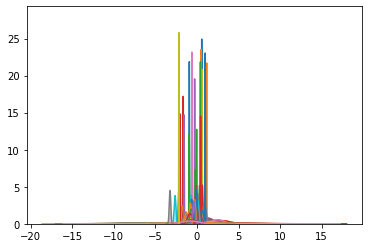

In [0]:
#attempt to plot the beta, not very successful
for c in range(119):
    sns.distplot(beta_samples[:,c])
#plt.legend(["beta[%d]" % c for c in range(119)])
plt.show()

We can now use the inferred posteriors to make predictions:

In [0]:
# extract expected values of the parameters
alpha_hat = samples["alpha"].mean(axis=0).detach().numpy()
beta_hat = samples["beta"].mean(axis=0).detach().numpy()

In [0]:
# make predictions for test set
Y_hat = alpha_hat + np.dot(X_test, beta_hat)

# evaluate prediction accuracy
print("Accuracy:", 1.0*np.sum(Y_hat == Y_test) / len(Y_test))
print(sum(Y_hat))

Accuracy: 0.0
-122274.56657075882
